First step is to import required libraries and utilities.

In [1]:
# -*- coding: utf-8 -*-
import json # For reading COCO annotations file
import cv2   # For image loading and manipulation
import numpy as np  # For numerical and array operations

from matplotlib import pyplot as plt   # For visualizing images

import os  # For file system access
from ultralytics import YOLO  # Model to train

### STEP I: Visualize Images

First, I set the path to the annotations file. Then I load the file using __json__ library, after which I specifically extract the specific information for the images and their respective annotations.

In [2]:
def return_split_files(split, dataset_folder = "stenosis_dataset", images = True):
    # Path to corresponding COCO annotations file
    if split == "test":
        ANN_PATH = "../extras/extra_coco_annotations.json"
    else:
        ANN_PATH = "../extras/coco_annotations.json"

    # Load annotations file
    file = json.load(open(ANN_PATH, "r"))

    ftype = "images" if images else "labels"
    
    image_base_dir = f"..datasets/{dataset_folder}/{ftype}/{split}"
    image_paths = [os.path.join(image_base_dir, f) for f in os.listdir(image_base_dir)]
    return image_paths

TEST_IMAGE_PATHS = return_split_files("test", "stenosis_dataset", True)
TEST_LABEL_PATHS = return_split_files("test", "stenosis_dataset", False)

### STEP II: Model Training

Now, I train the model. To do this, I need to ensure that the results are repproducible. I also need a configuration file telling the model where to find the data, and what labels to expect in the data.

In [3]:
import torch

In [4]:
# Ensure reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# Instantiate model
model = YOLO('yolov9c.pt')

In [6]:
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): RepNCSPELAN4(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Sequential(
          (0): RepCSP(
            (cv1): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              

In [7]:
# Load configuration file
CONFIG_FILE = os.path.join("..", "config", "stenosis_config.yaml")

In [8]:
# Set image size for training
ORIGINAL_IMGSZ = (694, 542)
# IMGSZ = 672
IMGSZ = 640
freeze = [2, 4, 6, 8, 12, 18, 21]

In [9]:
folder = "stenosis_yolov9c_freeze"

In [10]:
# Train model
results = model.train(
    data = CONFIG_FILE,
    visualize = True,
    epochs = 150,
    imgsz = IMGSZ,
    optimizer = "Adam",
    lr0 = 1e-3,
    batch = -1,
    pretrained = True,
    freeze = freeze,
    save = True,
    cos_lr = True,
    deterministic = True,
    auto_augment = "augmix",
    patience=0,
    copy_paste = 1.,
    hsv_h = .5,
    mixup = 1.,
    fliplr = 1.,
    name = folder
)

Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=../config/stenosis_config.yaml, epochs=150, time=None, patience=0, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=stenosis_yolov9c_freeze, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=[2, 4, 6, 8, 12, 18, 21], multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=True, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, 

/home/harkhymadhe/miniforge3/envs/mri/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025831482/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU) 8.00G total, 0.33G reserved, 0.24G allocated, 7.44G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    25532316       103.7         1.049         52.69         79.86        (1, 3, 640, 640)                    list
    25532316       207.4         1.705         53.44         57.99        (2, 3, 640, 640)                    list
    25532316       414.8         2.856         59.36         67.22        (4, 3, 640, 640)                    list
    25532316       829.6         5.476         101.8         108.3        (8, 3, 640, 640)                    list
    25532316        1659        10.414          2952          3102       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 6 for CUDA:0 4.74G/8.00G (59%) ✅


train: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/train.cache... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]
val: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/val.cache... 35 images, 0 backgrounds, 0 corrupt: 100%|██████████| 35/35 [00:00<?, ?it/s]


Plotting labels to runs/detect/stenosis_yolov9c_freeze/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.000515625), 160 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/stenosis_yolov9c_freeze
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      4.39G      5.941      14.55      3.043         17        640: 100%|██████████| 11/11 [00:03<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         35        239          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      4.42G       4.33      6.381      1.963         38        640: 100%|██████████| 11/11 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]


                   all         35        239      0.264      0.123     0.0106    0.00228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      4.49G       2.97      3.497      1.199         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]

                   all         35        239   0.000897      0.037   0.000416   8.25e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      4.48G      2.565      2.915      1.129         18        640: 100%|██████████| 11/11 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         35        239     0.0279      0.261     0.0226     0.0065



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      4.48G      2.466      2.456      1.116         14        640: 100%|██████████| 11/11 [00:02<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]

                   all         35        239     0.0294      0.141      0.022    0.00629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      4.48G       2.52        2.5       1.11         41        640: 100%|██████████| 11/11 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]

                   all         35        239      0.274      0.158     0.0197     0.0056



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      4.48G      2.584      2.288       1.16         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]

                   all         35        239     0.0143      0.143     0.0113    0.00381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      4.48G      2.424      2.128      1.084         16        640: 100%|██████████| 11/11 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]

                   all         35        239     0.0152      0.128     0.0101    0.00272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      4.49G      2.319      2.073      1.091         23        640: 100%|██████████| 11/11 [00:02<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]

                   all         35        239      0.261     0.0436     0.0065    0.00199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      4.48G      2.328      2.012      1.083         32        640: 100%|██████████| 11/11 [00:02<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.14it/s]

                   all         35        239    0.00558      0.184    0.00454    0.00144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      4.49G      2.385      1.964      1.113         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.04it/s]

                   all         35        239      0.259     0.0524    0.00509    0.00166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      4.49G      2.293      1.861      1.059         28        640: 100%|██████████| 11/11 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.54it/s]

                   all         35        239       0.27     0.0586     0.0116    0.00355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      4.48G      2.339      1.812      1.025         52        640: 100%|██████████| 11/11 [00:02<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]

                   all         35        239      0.536     0.0613     0.0173    0.00511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      4.49G       2.26       1.73      1.049         29        640: 100%|██████████| 11/11 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

                   all         35        239      0.543     0.0495     0.0187    0.00544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      4.49G      2.185      1.697      1.036         26        640: 100%|██████████| 11/11 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.16it/s]

                   all         35        239      0.274      0.103     0.0157    0.00485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      4.48G      2.194      1.729      1.043         40        640: 100%|██████████| 11/11 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.05it/s]

                   all         35        239      0.281     0.0642     0.0145    0.00485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      4.49G      2.153      1.749      1.021          7        640: 100%|██████████| 11/11 [00:02<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]

                   all         35        239      0.272      0.105     0.0187    0.00516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      4.48G      2.199      1.792      1.046         38        640: 100%|██████████| 11/11 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.08it/s]

                   all         35        239      0.529     0.0985     0.0242     0.0062



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      4.48G      2.237      1.894      1.037          9        640: 100%|██████████| 11/11 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]

                   all         35        239      0.525      0.104     0.0166    0.00464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      4.49G      2.058      1.694      1.002         13        640: 100%|██████████| 11/11 [00:02<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]

                   all         35        239      0.523     0.0949     0.0165    0.00459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      4.48G      2.136      1.657      1.028          9        640: 100%|██████████| 11/11 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]

                   all         35        239      0.528       0.09     0.0195    0.00543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      4.48G      2.155      1.585     0.9991         34        640: 100%|██████████| 11/11 [00:02<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.96it/s]

                   all         35        239      0.273      0.138      0.015    0.00465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      4.48G      2.124      1.591      1.002         46        640: 100%|██████████| 11/11 [00:02<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.92it/s]

                   all         35        239      0.276      0.118     0.0192    0.00553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      4.48G      2.051      1.588     0.9793          5        640: 100%|██████████| 11/11 [00:02<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.90it/s]

                   all         35        239      0.276      0.118      0.017    0.00551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      4.49G      2.096      1.575      1.002         17        640: 100%|██████████| 11/11 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]

                   all         35        239      0.276     0.0992     0.0173    0.00504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      4.48G      2.009      1.591          1         12        640: 100%|██████████| 11/11 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.92it/s]

                   all         35        239      0.276     0.0894     0.0184    0.00504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      4.49G      2.025      1.583      0.998         28        640: 100%|██████████| 11/11 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

                   all         35        239      0.283     0.0881     0.0237    0.00669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      4.48G      1.994      1.562     0.9958         20        640: 100%|██████████| 11/11 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.05it/s]

                   all         35        239      0.285      0.102     0.0211     0.0061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      4.48G      2.062      1.568     0.9998         20        640: 100%|██████████| 11/11 [00:02<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

                   all         35        239      0.282      0.117     0.0205    0.00614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      4.48G      1.993        1.5     0.9685         17        640: 100%|██████████| 11/11 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.06it/s]

                   all         35        239      0.279      0.104     0.0201    0.00572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      4.48G      2.127       1.53      1.005          9        640: 100%|██████████| 11/11 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.04it/s]

                   all         35        239      0.278     0.0992     0.0181     0.0057



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      4.48G      2.001      1.508     0.9822         21        640: 100%|██████████| 11/11 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

                   all         35        239      0.279      0.104     0.0167     0.0057



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      4.49G      1.958      1.382     0.9713         19        640: 100%|██████████| 11/11 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]

                   all         35        239      0.273     0.0835     0.0166    0.00559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      4.48G      2.009      1.393     0.9856         44        640: 100%|██████████| 11/11 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.06it/s]

                   all         35        239      0.275     0.0969     0.0155    0.00522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      4.49G      1.938      1.452      0.965         45        640: 100%|██████████| 11/11 [00:02<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.71it/s]

                   all         35        239      0.278     0.0913     0.0149    0.00511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      4.49G      1.948      1.415     0.9833         11        640: 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.67it/s]

                   all         35        239      0.281     0.0808     0.0168    0.00579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      4.49G      1.948      1.404     0.9723         22        640: 100%|██████████| 11/11 [00:02<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.05it/s]

                   all         35        239      0.276     0.0604     0.0171    0.00593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      4.48G      1.942       1.46     0.9736         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.83it/s]

                   all         35        239       0.28     0.0716     0.0188    0.00663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      4.49G      1.861      1.337     0.9377         26        640: 100%|██████████| 11/11 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

                   all         35        239      0.276     0.0689     0.0199    0.00703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      4.48G      1.939      1.439     0.9705         41        640: 100%|██████████| 11/11 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

                   all         35        239      0.278     0.0835     0.0216    0.00704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      4.48G      1.911      1.352      0.951         36        640: 100%|██████████| 11/11 [00:02<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.08it/s]

                   all         35        239      0.278     0.0808     0.0203    0.00628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      4.48G       1.87      1.396     0.9426         16        640: 100%|██████████| 11/11 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         35        239      0.279      0.106     0.0194    0.00595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      4.49G      1.837      1.345     0.9375         10        640: 100%|██████████| 11/11 [00:02<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.05it/s]

                   all         35        239      0.284      0.108     0.0192    0.00568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      4.49G      1.901      1.375     0.9854          8        640: 100%|██████████| 11/11 [00:02<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.92it/s]

                   all         35        239      0.285      0.101     0.0212    0.00632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      4.49G      1.942      1.378     0.9663         30        640: 100%|██████████| 11/11 [00:02<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]

                   all         35        239      0.285      0.107     0.0215    0.00677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      4.48G      1.948      1.359      0.967         19        640: 100%|██████████| 11/11 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]

                   all         35        239      0.282      0.106     0.0213     0.0063



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      4.49G      1.793      1.341      0.944         24        640: 100%|██████████| 11/11 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.82it/s]

                   all         35        239      0.287      0.125     0.0228    0.00655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      4.49G      1.784      1.291     0.9481         22        640: 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]

                   all         35        239      0.291      0.127      0.025    0.00728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      4.48G      1.806      1.233     0.9308         21        640: 100%|██████████| 11/11 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]

                   all         35        239      0.294      0.125     0.0258    0.00763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      4.49G      1.847      1.329     0.9348         16        640: 100%|██████████| 11/11 [00:02<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.86it/s]

                   all         35        239      0.535     0.0972     0.0224    0.00708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      4.49G      1.777      1.331     0.9586         20        640: 100%|██████████| 11/11 [00:02<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]

                   all         35        239      0.282      0.117     0.0228    0.00712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      4.48G      1.836      1.306     0.9269         32        640: 100%|██████████| 11/11 [00:02<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.88it/s]

                   all         35        239      0.284      0.107     0.0225    0.00763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      4.48G      1.822      1.277     0.9533         13        640: 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

                   all         35        239      0.278     0.0837     0.0187    0.00627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      4.49G      1.816      1.363     0.9604         10        640: 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]

                   all         35        239      0.273     0.0764     0.0154     0.0051



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      4.48G      1.748      1.244     0.9277         16        640: 100%|██████████| 11/11 [00:02<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.04it/s]

                   all         35        239      0.275       0.12     0.0164    0.00551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      4.49G        1.8      1.228     0.9348         32        640: 100%|██████████| 11/11 [00:02<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all         35        239      0.283      0.108     0.0211    0.00708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      4.48G      1.831      1.261     0.9571         14        640: 100%|██████████| 11/11 [00:02<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.75it/s]

                   all         35        239      0.291      0.105     0.0244    0.00807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      4.49G      1.793      1.299     0.9436         24        640: 100%|██████████| 11/11 [00:02<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.58it/s]

                   all         35        239      0.287      0.098     0.0233    0.00766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      4.48G      1.723      1.214     0.9444         19        640: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]

                   all         35        239      0.283     0.0915     0.0214    0.00726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      4.49G      1.692      1.185     0.9251         23        640: 100%|██████████| 11/11 [00:02<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]

                   all         35        239      0.285      0.101      0.021    0.00747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      4.48G      1.735      1.198     0.9164         38        640: 100%|██████████| 11/11 [00:02<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]

                   all         35        239      0.284      0.102     0.0202    0.00732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      4.48G      1.729      1.208     0.9389         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]

                   all         35        239       0.28       0.11     0.0195    0.00716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      4.49G       1.73      1.224     0.9428         18        640: 100%|██████████| 11/11 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

                   all         35        239       0.28      0.101     0.0211      0.007



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      4.49G      1.713      1.187     0.9318         30        640: 100%|██████████| 11/11 [00:02<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.79it/s]

                   all         35        239      0.535     0.0946      0.022    0.00736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      4.49G      1.687      1.164     0.9092         24        640: 100%|██████████| 11/11 [00:02<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.47it/s]

                   all         35        239      0.538      0.092     0.0218    0.00768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      4.48G      1.658      1.156     0.9185         49        640: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.92it/s]

                   all         35        239      0.541      0.087     0.0215     0.0078



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      4.48G      1.656      1.174     0.9388          6        640: 100%|██████████| 11/11 [00:02<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]

                   all         35        239      0.289     0.0956     0.0209    0.00717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      4.49G      1.656      1.155     0.9176         35        640: 100%|██████████| 11/11 [00:02<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]

                   all         35        239       0.29     0.0903     0.0198    0.00693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      4.48G      1.651      1.118      0.904         18        640: 100%|██████████| 11/11 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all         35        239      0.281     0.0725     0.0165    0.00573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      4.49G       1.71       1.21     0.9272         18        640: 100%|██████████| 11/11 [00:02<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.20it/s]

                   all         35        239      0.279     0.0966     0.0167     0.0061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      4.49G      1.617      1.114     0.9091         17        640: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]

                   all         35        239      0.278     0.0904     0.0193    0.00661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      4.47G      1.701      1.162      0.942         32        640: 100%|██████████| 11/11 [00:02<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]

                   all         35        239       0.28     0.0759     0.0209    0.00694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      4.48G      1.658      1.072     0.9226         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]

                   all         35        239      0.288     0.0858     0.0225    0.00772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      4.49G      1.733       1.15     0.9339         14        640: 100%|██████████| 11/11 [00:02<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.88it/s]

                   all         35        239      0.297     0.0752     0.0275    0.00838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      4.49G      1.637      1.129     0.9053         28        640: 100%|██████████| 11/11 [00:02<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.05it/s]

                   all         35        239      0.304     0.0726     0.0307     0.0085



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      4.47G      1.637      1.097     0.9192         11        640: 100%|██████████| 11/11 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.04it/s]

                   all         35        239      0.289     0.0835     0.0276    0.00761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      4.48G      1.691      1.124     0.9201         32        640: 100%|██████████| 11/11 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all         35        239      0.289     0.0983     0.0244    0.00703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      4.49G      1.659      1.129     0.9244         20        640: 100%|██████████| 11/11 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.99it/s]

                   all         35        239      0.284      0.091     0.0229    0.00699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      4.49G      1.721      1.173     0.9346         19        640: 100%|██████████| 11/11 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.67it/s]

                   all         35        239      0.289      0.107      0.025    0.00745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      4.49G      1.606       1.08     0.9072         22        640: 100%|██████████| 11/11 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.85it/s]

                   all         35        239      0.289      0.089     0.0243    0.00771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      4.48G      1.565      1.051     0.9137         29        640: 100%|██████████| 11/11 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.04it/s]

                   all         35        239      0.289      0.101     0.0272    0.00797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      4.48G      1.683      1.142      0.923         49        640: 100%|██████████| 11/11 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

                   all         35        239        0.3     0.0833     0.0312    0.00938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      4.48G       1.63      1.063     0.9238         13        640: 100%|██████████| 11/11 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.90it/s]

                   all         35        239      0.559     0.0933     0.0373     0.0109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      4.48G      1.563     0.9738     0.8901         31        640: 100%|██████████| 11/11 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.90it/s]

                   all         35        239      0.564     0.0907     0.0393     0.0122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      4.48G      1.558      1.011     0.8847         26        640: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]

                   all         35        239      0.562     0.0933     0.0393     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      4.48G      1.543       1.06     0.9027         16        640: 100%|██████████| 11/11 [00:02<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.53it/s]

                   all         35        239      0.562     0.0789     0.0358     0.0116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      4.49G       1.58      1.018     0.9054         20        640: 100%|██████████| 11/11 [00:02<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.55it/s]

                   all         35        239      0.561     0.0937     0.0342     0.0111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      4.48G      1.552       1.02     0.8988         16        640: 100%|██████████| 11/11 [00:02<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]

                   all         35        239      0.557     0.0913      0.031     0.0104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      4.48G      1.533      1.044     0.9061         18        640: 100%|██████████| 11/11 [00:02<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.05it/s]

                   all         35        239      0.555     0.0864     0.0298    0.00998



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      4.49G      1.609      1.086     0.9149         16        640: 100%|██████████| 11/11 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]

                   all         35        239      0.548     0.0838     0.0283    0.00958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      4.48G      1.624      1.122      0.939          7        640: 100%|██████████| 11/11 [00:02<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]

                   all         35        239       0.55     0.0907     0.0284    0.00938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      4.48G      1.513      1.065     0.9192         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]

                   all         35        239      0.546     0.0835     0.0276    0.00914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      4.48G      1.553      1.043      0.925         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]

                   all         35        239      0.546     0.0884     0.0257    0.00887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      4.47G      1.583       1.01      0.901         33        640: 100%|██████████| 11/11 [00:02<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.76it/s]

                   all         35        239      0.546      0.093     0.0265    0.00865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      4.48G      1.542      1.033     0.9124         17        640: 100%|██████████| 11/11 [00:02<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.74it/s]

                   all         35        239      0.537        0.1     0.0276     0.0085



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      4.48G      1.583       1.03     0.9059         27        640: 100%|██████████| 11/11 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.79it/s]

                   all         35        239      0.537        0.1     0.0275    0.00841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      4.48G      1.552      1.108     0.8977         16        640: 100%|██████████| 11/11 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

                   all         35        239      0.536      0.103     0.0271    0.00825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      4.48G      1.525       0.99     0.8901         13        640: 100%|██████████| 11/11 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.95it/s]

                   all         35        239      0.543      0.105     0.0279    0.00861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      4.48G      1.587      1.102     0.8998         22        640: 100%|██████████| 11/11 [00:02<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.96it/s]

                   all         35        239      0.549       0.11     0.0284    0.00843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      4.49G      1.514       1.03     0.8914         13        640: 100%|██████████| 11/11 [00:02<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all         35        239      0.547      0.106     0.0291    0.00857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      4.48G       1.54      1.011     0.8968         18        640: 100%|██████████| 11/11 [00:02<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.85it/s]

                   all         35        239       0.55      0.108     0.0296    0.00902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      4.48G      1.568       1.05      0.893          8        640: 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]

                   all         35        239      0.549      0.102     0.0301    0.00933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      4.48G      1.577      1.021     0.8906         24        640: 100%|██████████| 11/11 [00:02<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.96it/s]

                   all         35        239      0.551     0.0989     0.0322    0.00978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      4.49G      1.488     0.9705     0.8947         22        640: 100%|██████████| 11/11 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]

                   all         35        239       0.55      0.101     0.0328    0.00988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      4.48G      1.532       1.04     0.8926         29        640: 100%|██████████| 11/11 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.99it/s]

                   all         35        239      0.553      0.101     0.0329    0.00972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      4.48G      1.493     0.9726     0.8959         17        640: 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.74it/s]

                   all         35        239      0.551     0.0983     0.0322    0.00956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      4.48G      1.463     0.9875     0.8881         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]

                   all         35        239      0.549      0.102     0.0315    0.00906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      4.48G      1.464     0.9954     0.8869          5        640: 100%|██████████| 11/11 [00:02<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.90it/s]

                   all         35        239      0.553      0.104     0.0323    0.00927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      4.47G      1.513      1.063     0.8954          6        640: 100%|██████████| 11/11 [00:02<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         35        239      0.554      0.089     0.0321    0.00922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      4.48G      1.434     0.9985     0.8866         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.85it/s]

                   all         35        239      0.558     0.0917      0.034     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      4.49G      1.514     0.9968     0.9041         18        640: 100%|██████████| 11/11 [00:02<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.61it/s]

                   all         35        239      0.553     0.0917     0.0338     0.0102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      4.48G      1.494     0.9837     0.8905         34        640: 100%|██████████| 11/11 [00:02<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.83it/s]

                   all         35        239      0.554     0.0996     0.0337     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      4.49G      1.478     0.9938      0.899         24        640: 100%|██████████| 11/11 [00:02<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.91it/s]

                   all         35        239      0.552     0.0818     0.0341     0.0104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      4.48G      1.505     0.9972     0.9051         14        640: 100%|██████████| 11/11 [00:02<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

                   all         35        239      0.555      0.087     0.0358     0.0108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      4.48G      1.523      1.016     0.8971         54        640: 100%|██████████| 11/11 [00:02<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.88it/s]

                   all         35        239      0.554       0.09     0.0346     0.0104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      4.49G      1.494     0.9792     0.8906         20        640: 100%|██████████| 11/11 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.88it/s]

                   all         35        239      0.559     0.0932     0.0349     0.0107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      4.48G      1.435     0.9321     0.8823         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.51it/s]

                   all         35        239      0.554     0.0818     0.0347     0.0104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      4.49G      1.407     0.9456     0.8867         21        640: 100%|██████████| 11/11 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]

                   all         35        239      0.555     0.0768     0.0337     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      4.48G      1.418     0.9519     0.8965         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

                   all         35        239       0.56     0.0821     0.0325    0.00968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      4.48G      1.447     0.9238     0.8879          7        640: 100%|██████████| 11/11 [00:02<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.99it/s]

                   all         35        239      0.558     0.0818     0.0336    0.00951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      4.49G      1.431      0.917     0.8575         17        640: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]

                   all         35        239      0.557     0.0867     0.0316    0.00929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      4.49G      1.431     0.9315     0.8903         14        640: 100%|██████████| 11/11 [00:02<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]

                   all         35        239      0.554     0.0844     0.0313    0.00942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      4.47G      1.435     0.9316     0.8939         36        640: 100%|██████████| 11/11 [00:02<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]

                   all         35        239      0.558     0.0775       0.03     0.0091



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      4.49G      1.403     0.9471     0.8815         31        640: 100%|██████████| 11/11 [00:02<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.46it/s]

                   all         35        239      0.557     0.0863     0.0314    0.00924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      4.48G      1.358     0.9032     0.8839         14        640: 100%|██████████| 11/11 [00:02<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.81it/s]

                   all         35        239      0.558     0.0943     0.0305    0.00923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      4.48G      1.461     0.9635     0.8909         16        640: 100%|██████████| 11/11 [00:02<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]

                   all         35        239      0.562      0.094     0.0321    0.00929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      4.48G      1.411     0.8973     0.8749         42        640: 100%|██████████| 11/11 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.74it/s]

                   all         35        239      0.561     0.0917     0.0321    0.00942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      4.48G        1.4     0.8829      0.875         29        640: 100%|██████████| 11/11 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.80it/s]

                   all         35        239      0.558     0.0943      0.032    0.00942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      4.48G       1.46     0.9659     0.8972         13        640: 100%|██████████| 11/11 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]

                   all         35        239       0.55     0.0894     0.0302    0.00899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      4.48G      1.389     0.9317     0.8626         28        640: 100%|██████████| 11/11 [00:02<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]

                   all         35        239       0.55     0.0894     0.0296     0.0089



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      4.47G      1.338     0.8518      0.894          6        640: 100%|██████████| 11/11 [00:02<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]

                   all         35        239      0.553     0.0917      0.029    0.00866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      4.48G      1.404     0.9061     0.8624         35        640: 100%|██████████| 11/11 [00:02<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]

                   all         35        239      0.551      0.087     0.0289    0.00899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      4.48G      1.405     0.9143     0.8828         11        640: 100%|██████████| 11/11 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.96it/s]

                   all         35        239       0.55     0.0894     0.0283    0.00894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      4.49G      1.404     0.9058     0.8847         24        640: 100%|██████████| 11/11 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.77it/s]

                   all         35        239       0.55     0.0844     0.0283    0.00898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      4.48G      1.459     0.8985      0.918         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.91it/s]

                   all         35        239      0.549     0.0894     0.0296    0.00934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      4.47G      1.409     0.9103     0.8641         36        640: 100%|██████████| 11/11 [00:02<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

                   all         35        239      0.547     0.0894      0.029    0.00904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      4.47G      1.397     0.8646     0.8746         38        640: 100%|██████████| 11/11 [00:02<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.83it/s]

                   all         35        239      0.553     0.0844     0.0291    0.00919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      4.47G      1.268     0.8557     0.8726          5        640: 100%|██████████| 11/11 [00:02<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.72it/s]

                   all         35        239      0.552     0.0847     0.0286    0.00917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      4.48G      1.432     0.9328     0.8816         14        640: 100%|██████████| 11/11 [00:02<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.45it/s]

                   all         35        239      0.547     0.0847     0.0281    0.00907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      4.49G      1.346     0.8954     0.8839         29        640: 100%|██████████| 11/11 [00:02<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.62it/s]

                   all         35        239       0.55     0.0897     0.0284    0.00918


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      4.47G       1.26     0.8321     0.8722          6        640: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.58it/s]

                   all         35        239      0.552     0.0943     0.0298    0.00891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      4.48G      1.369     0.9485     0.8866          6        640: 100%|██████████| 11/11 [00:02<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         35        239      0.559     0.0567     0.0326    0.00898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      4.48G      1.301     0.9122     0.8821          7        640: 100%|██████████| 11/11 [00:02<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.83it/s]

                   all         35        239      0.561     0.0594      0.031    0.00871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      4.48G      1.273      1.101     0.8822          7        640: 100%|██████████| 11/11 [00:02<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.92it/s]

                   all         35        239      0.551     0.0716     0.0308    0.00873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      4.48G      1.268     0.8531     0.8778          6        640: 100%|██████████| 11/11 [00:02<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]

                   all         35        239      0.558     0.0666     0.0292    0.00835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      4.47G      1.248     0.8046     0.8701          7        640: 100%|██████████| 11/11 [00:02<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.13it/s]

                   all         35        239      0.561     0.0692     0.0297    0.00854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      4.48G      1.172     0.7942     0.8633          6        640: 100%|██████████| 11/11 [00:02<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]

                   all         35        239      0.563     0.0739     0.0295    0.00838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      4.48G      1.218     0.8113     0.8711          8        640: 100%|██████████| 11/11 [00:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.92it/s]

                   all         35        239      0.555     0.0671     0.0292    0.00841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      4.48G      1.251     0.8397     0.8671          7        640: 100%|██████████| 11/11 [00:02<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]

                   all         35        239      0.557     0.0716     0.0293    0.00863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      4.49G      1.261     0.8059     0.8628          6        640: 100%|██████████| 11/11 [00:02<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.74it/s]

                   all         35        239      0.557     0.0692     0.0286    0.00839



150 epochs completed in 0.170 hours.
Optimizer stripped from runs/detect/stenosis_yolov9c_freeze/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/stenosis_yolov9c_freeze/weights/best.pt, 51.6MB

Validating runs/detect/stenosis_yolov9c_freeze/weights/best.pt...
Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
YOLOv9c summary (fused): 384 layers, 25322332 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


                   all         35        239      0.563     0.0907     0.0391      0.012
      Grade 0 Stenosis         35         12          1          0          0          0
      Grade 1 Stenosis         35         24          1          0      0.001   0.000602
      Grade 2 Stenosis         35         95     0.0934      0.168     0.0511     0.0215
      Grade 3 Stenosis         35        108       0.16      0.194      0.104     0.0257
Speed: 0.4ms preprocess, 19.4ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/stenosis_yolov9c_freeze


In [11]:
results

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa8fffbc910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [12]:
def return_split_files(split, dataset_folder = "dataset", images = True):
    # Path to corresponding COCO annotations file
    if split == "test":
        ANN_PATH = "../extras/extra_coco_annotations.json"
    else:
        ANN_PATH = "../extras/coco_annotations.json"

    # Load annotations file
    file = json.load(open(ANN_PATH, "r"))

    ftype = "images" if images else "labels"
    
    image_base_dir = f"../datasets/{dataset_folder}/{ftype}/{split}"
    image_paths = [os.path.join(image_base_dir, f) for f in os.listdir(image_base_dir)]
    return image_paths

In [13]:
TRAIN_IMAGE_PATHS = return_split_files("train", "stenosis_dataset", True)
TRAIN_LABEL_PATHS = return_split_files("train", "stenosis_dataset", False)

In [14]:
VAL_IMAGE_PATHS = return_split_files("val", "stenosis_dataset", True)
VAL_LABEL_PATHS = return_split_files("val", "stenosis_dataset", False)

In [15]:
TEST_IMAGE_PATHS = return_split_files("test", "stenosis_dataset", True)
TEST_LABEL_PATHS = return_split_files("test", "stenosis_dataset", False)

---

Now we test and evaluate the model.

In [16]:
del model

In [17]:
import gc
gc.collect()

54894

In [18]:
# Load trained model
model = YOLO("runs/detect/stenosis_yolov9c_freeze/weights/best.pt")

In [19]:
model.val(split = "train", name = folder)

Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
YOLOv9c summary (fused): 384 layers, 25322332 parameters, 0 gradients, 102.3 GFLOPs


val: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/train.cache... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


                   all         61        412      0.491      0.176      0.064     0.0159
      Grade 0 Stenosis         61         26          1          0          0          0
      Grade 1 Stenosis         61         31      0.761      0.129       0.11      0.017
      Grade 2 Stenosis         61        207      0.102      0.271     0.0688     0.0245
      Grade 3 Stenosis         61        148        0.1      0.304     0.0766     0.0221
Speed: 0.8ms preprocess, 25.0ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/stenosis_yolov9c_freeze2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa914e79340>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [20]:
model.val(split = "val", name = folder)

Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)


val: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/val.cache... 35 images, 0 backgrounds, 0 corrupt: 100%|██████████| 35/35 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


                   all         35        239      0.561     0.0907     0.0398      0.012
      Grade 0 Stenosis         35         12          1          0          0          0
      Grade 1 Stenosis         35         24          1          0    0.00321    0.00104
      Grade 2 Stenosis         35         95     0.0911      0.168      0.052     0.0212
      Grade 3 Stenosis         35        108      0.154      0.194      0.104     0.0257
Speed: 0.4ms preprocess, 27.0ms inference, 0.0ms loss, 5.8ms postprocess per image
Results saved to runs/detect/stenosis_yolov9c_freeze3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa9d05fbdc0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [21]:
model.val(split = "test", name = folder)

Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)


val: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/test.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


                   all         38        234      0.525     0.0379     0.0175    0.00436
      Grade 0 Stenosis         38         20          1          0          0          0
      Grade 1 Stenosis         38          4          1          0          0          0
      Grade 2 Stenosis         38         98     0.0422     0.0714     0.0176    0.00499
      Grade 3 Stenosis         38        112     0.0586     0.0804     0.0524     0.0124
Speed: 0.7ms preprocess, 28.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/stenosis_yolov9c_freeze4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa914ed5d30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

---

Now we test the model to visualize predictions.

In [22]:
conf = .25

In [23]:
PREDS = model.predict(
    TRAIN_IMAGE_PATHS,
    imgsz = 640,
    conf = conf,
    iou = .8,
    show_boxes = False,
    augment = True
)

0: 512x640 9 Grade 3 Stenosiss, 29.2ms
1: 512x640 7 Grade 3 Stenosiss, 29.2ms
2: 512x640 9 Grade 3 Stenosiss, 29.2ms
3: 512x640 14 Grade 2 Stenosiss, 29.2ms
4: 512x640 13 Grade 2 Stenosiss, 29.2ms
5: 512x640 10 Grade 2 Stenosiss, 1 Grade 3 Stenosis, 29.2ms
6: 512x640 11 Grade 2 Stenosiss, 2 Grade 3 Stenosiss, 29.2ms
7: 512x640 9 Grade 2 Stenosiss, 1 Grade 3 Stenosis, 29.2ms
8: 512x640 7 Grade 2 Stenosiss, 29.2ms
9: 512x640 6 Grade 2 Stenosiss, 29.2ms
10: 512x640 8 Grade 2 Stenosiss, 3 Grade 3 Stenosiss, 29.2ms
11: 512x640 9 Grade 2 Stenosiss, 4 Grade 3 Stenosiss, 29.2ms
12: 512x640 6 Grade 2 Stenosiss, 7 Grade 3 Stenosiss, 29.2ms
13: 512x640 10 Grade 2 Stenosiss, 29.2ms
14: 512x640 10 Grade 2 Stenosiss, 29.2ms
15: 512x640 12 Grade 2 Stenosiss, 29.2ms
16: 512x640 9 Grade 2 Stenosiss, 29.2ms
17: 512x640 3 Grade 2 Stenosiss, 2 Grade 3 Stenosiss, 29.2ms
18: 512x640 8 Grade 2 Stenosiss, 1 Grade 3 Stenosis, 29.2ms
19: 512x640 7 Grade 2 Stenosiss, 1 Grade 3 Stenosis, 29.2ms
20: 512x640 12 Gra

In [24]:
pred_masks = [mask.boxes.cpu().data.numpy() for mask in PREDS]

In [25]:
pred_masks[0]

array([[      394.2,      286.62,      424.32,      303.16,     0.85787,           3],
       [     395.09,      318.68,      425.65,      334.89,     0.77449,           3],
       [     395.98,      256.33,      424.92,      271.53,       0.771,           3],
       [     395.37,      285.93,      423.32,      301.05,      0.6024,           3],
       [     402.97,      352.43,      433.37,      365.39,     0.49234,           3],
       [     398.61,      221.13,      429.43,      233.53,     0.48198,           3],
       [     401.88,      350.92,      433.68,      364.44,     0.43391,           3],
       [     396.77,      283.92,       425.1,      296.95,     0.29285,           3],
       [     396.66,      278.72,      425.06,      294.66,     0.27116,           3]], dtype=float32)

In [26]:
PREDS[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([3., 3., 3., 3., 3., 3., 3., 3., 3.], device='cuda:0')
conf: tensor([0.8579, 0.7745, 0.7710, 0.6024, 0.4923, 0.4820, 0.4339, 0.2929, 0.2712], device='cuda:0')
data: tensor([[3.9420e+02, 2.8662e+02, 4.2432e+02, 3.0316e+02, 8.5787e-01, 3.0000e+00],
        [3.9509e+02, 3.1868e+02, 4.2565e+02, 3.3489e+02, 7.7449e-01, 3.0000e+00],
        [3.9598e+02, 2.5633e+02, 4.2492e+02, 2.7153e+02, 7.7100e-01, 3.0000e+00],
        [3.9537e+02, 2.8593e+02, 4.2332e+02, 3.0105e+02, 6.0240e-01, 3.0000e+00],
        [4.0297e+02, 3.5243e+02, 4.3337e+02, 3.6539e+02, 4.9234e-01, 3.0000e+00],
        [3.9861e+02, 2.2113e+02, 4.2943e+02, 2.3353e+02, 4.8198e-01, 3.0000e+00],
        [4.0188e+02, 3.5092e+02, 4.3368e+02, 3.6444e+02, 4.3391e-01, 3.0000e+00],
        [3.9677e+02, 2.8392e+02, 4.2510e+02, 2.9695e+02, 2.9285e-01, 3.0000e+00],
        [3.9666e+02, 2.7872e+02, 4.2506e+02, 2.9466e+02, 2.7116e-01, 3.0000e+00]], device='cuda:0')
id: None


In [27]:
b = PREDS[0]

In [28]:
b.boxes.xyxy.shape[0]

9

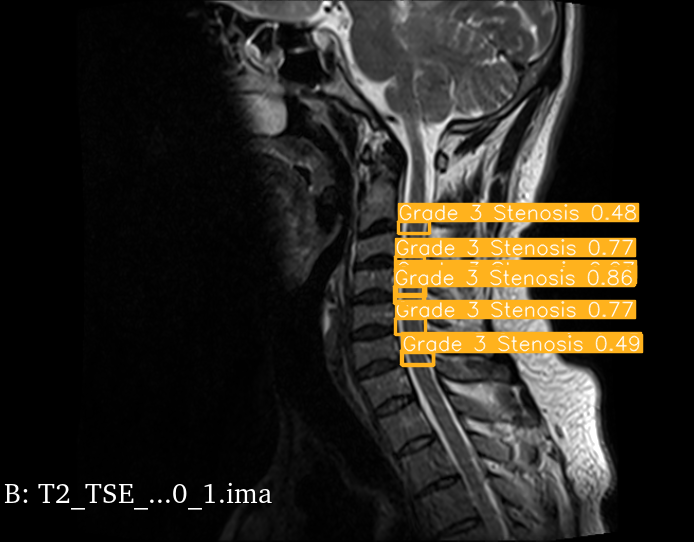

In [29]:
im = b.show()

In [30]:
im